### creating object with sync video and parse telemetry

In [2]:
from utilities.TelementryVideoSync import TelemetryVideoSync
from utilities.PX4CSVPlotter import PX4CSVPlotter
import os
from collections import namedtuple
import numpy as np
import pickle

# --------------------------------------------------
# CONFIG
# --------------------------------------------------
DATA_DIR = "data/1/"
pickle_path = os.path.join(DATA_DIR, "data.pkl")
video_path = os.path.join(DATA_DIR, "mp4.mp4")
output_path = os.path.join(DATA_DIR, "output.mp4")
ulog_path = os.path.join(DATA_DIR, "ulg.ulg")
csv_path = os.path.join(DATA_DIR, "csv")
Data = namedtuple("Data", ["frames", "gps_time", "gps_alt", "yaw", "pitch", "roll"])

TELEMETRY_START_IDX = 16970
TELEMETRY_END_IDX = 63418

VIDEO_START_MESS = 22.31860479142235
VIDEO_END_MESS = 457.5700117272575

SAVE_EVERY_N = 1
PLOT_EVERY_N = 10




In [6]:


# --------------------------------------------------
# CREATE OBJECT
# --------------------------------------------------

sync = TelemetryVideoSync(
    telemetry_start_idx=TELEMETRY_START_IDX,
    telemetry_end_idx=TELEMETRY_END_IDX,
    video_start_time=VIDEO_START_MESS,
    video_end_time=VIDEO_END_MESS,
    video_path=video_path,
    ulog_path=ulog_path,
    csv_path=csv_path,
    save_every_n=SAVE_EVERY_N,
    plot_every_n=PLOT_EVERY_N,
)
# --------------------------------------------------
# PIPELINE
# --------------------------------------------------

# 1. Convert ULOG → CSV (run once)
sync.read_telemetry()

# 2. Load telemetry, cut, resample, load video frames
sync.analyze_telemetry()

# 3. Play synchronized telemetry video
# sync.play_telemetry_video()

actuator_armed
actuator_motors
actuator_outputs
battery_status
config_overrides
control_allocator_status
cpuload
distance_sensor_mode_change_request
ekf2_timestamps
esc_status
estimator_aid_src_baro_hgt
estimator_aid_src_fake_hgt
estimator_aid_src_fake_pos
estimator_aid_src_gnss_hgt
estimator_aid_src_gnss_pos
estimator_aid_src_gnss_vel
estimator_aid_src_gravity
estimator_aid_src_mag
estimator_baro_bias
estimator_event_flags
estimator_gps_status
estimator_innovation_test_ratios
estimator_innovation_variances
estimator_innovations
estimator_sensor_bias
estimator_states
estimator_status
estimator_status_flags
event
failsafe_flags
failure_detector_status
gripper
home_position
hover_thrust_estimate
landing_gear
manual_control_setpoint
mission_result
navigator_mission_item
navigator_status
parameter_update
position_setpoint_triplet
rate_ctrl_status
rtl_status
rtl_time_estimate
sensor_accel
sensor_baro
sensor_combined
sensor_gps
sensor_gyro
sensor_gyro_fft
sensor_mag
sensor_selection
sensors_

Reading frames:  18%|█▊        | 1061/5969 [00:05<00:24, 199.46it/s]


KeyboardInterrupt: 

In [2]:
print("frames shape:", sync.frames.shape)
print("gps_time shape:", sync.gps_time.shape)
print("gps_alt shape:", sync.gps_alt.shape)
print("yaw shape:", sync.yaw.shape)
print("pitch shape:", sync.pitch.shape)
print("roll shape:", sync.roll.shape)

frames shape: (5636, 960, 1280, 3)
gps_time shape: (5636,)
gps_alt shape: (5636,)
yaw shape: (5636,)
pitch shape: (5636,)
roll shape: (5636,)


In [3]:



step = 2

data = Data(
    frames=np.array(sync.frames)[::step],
    gps_time=np.array(sync.gps_time)[::step],
    gps_alt=np.array(sync.gps_alt)[::step],
    yaw=np.array(sync.yaw)[::step],
    pitch=np.array(sync.pitch)[::step],
    roll=np.array(sync.roll)[::step],
)
del sync

In [4]:
with open(pickle_path, "wb") as f:
    pickle.dump(data, f)


In [6]:

del data

import gc
gc.collect()


1102

In [3]:
import pickle


with open(pickle_path, "rb") as f:
    data = pickle.load(f)


In [4]:
every_n_row = 2

data = Data(*(arr[::every_n_row] for arr in data))

In [5]:
threshold = 1

mask = (np.abs(data.pitch) <= threshold) & (np.abs(data.roll) <= threshold)

data = Data(
    frames=data.frames[mask],
    gps_time=data.gps_time[mask],
    gps_alt=data.gps_alt[mask],
    yaw=data.yaw[mask],
    pitch=data.pitch[mask],
    roll=data.roll[mask],
)



In [6]:
# import cv2
# yaw = (data.yaw + 360) % 360
#
#
# rotated_frames = []
# for img, y in zip(data.frames, yaw):
#     M = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), -y, 1)
#     rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
#     rotated_frames.append(rotated)
#
# data = Data(
#     frames=np.array(rotated_frames),
#     gps_time=data.gps_time,
#     gps_alt=data.gps_alt,
#     yaw=yaw,
#     pitch=data.pitch,
#     roll=data.roll,
# )


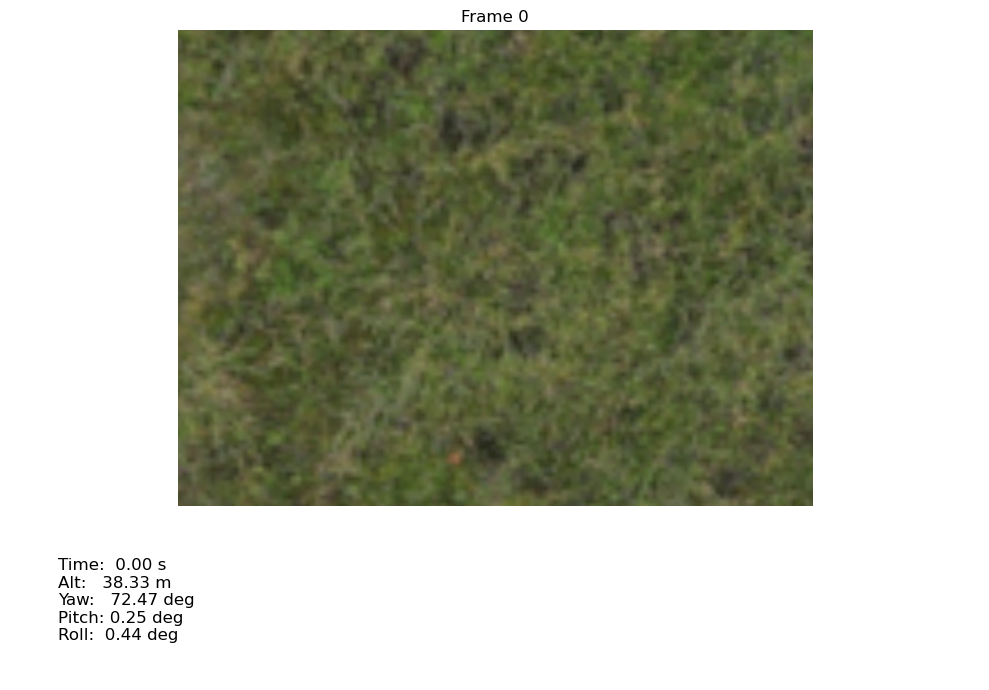

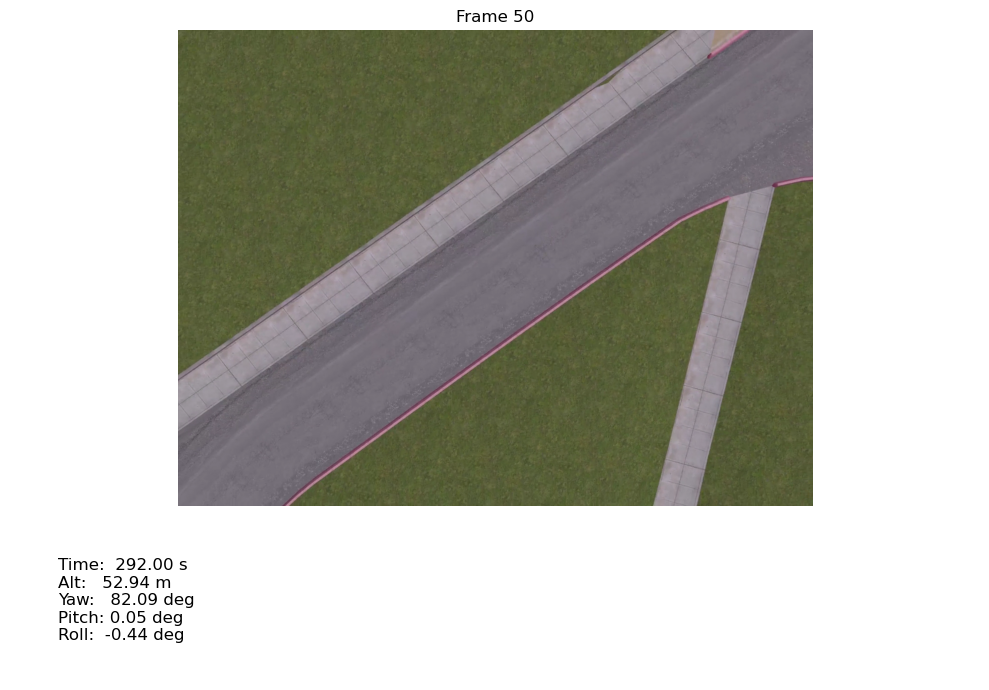

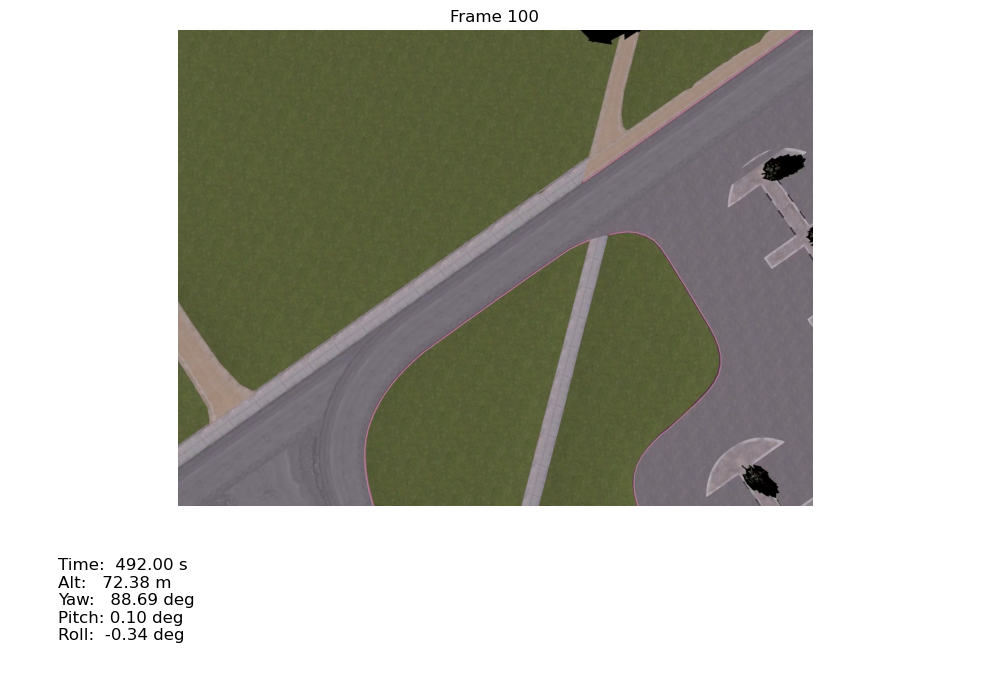

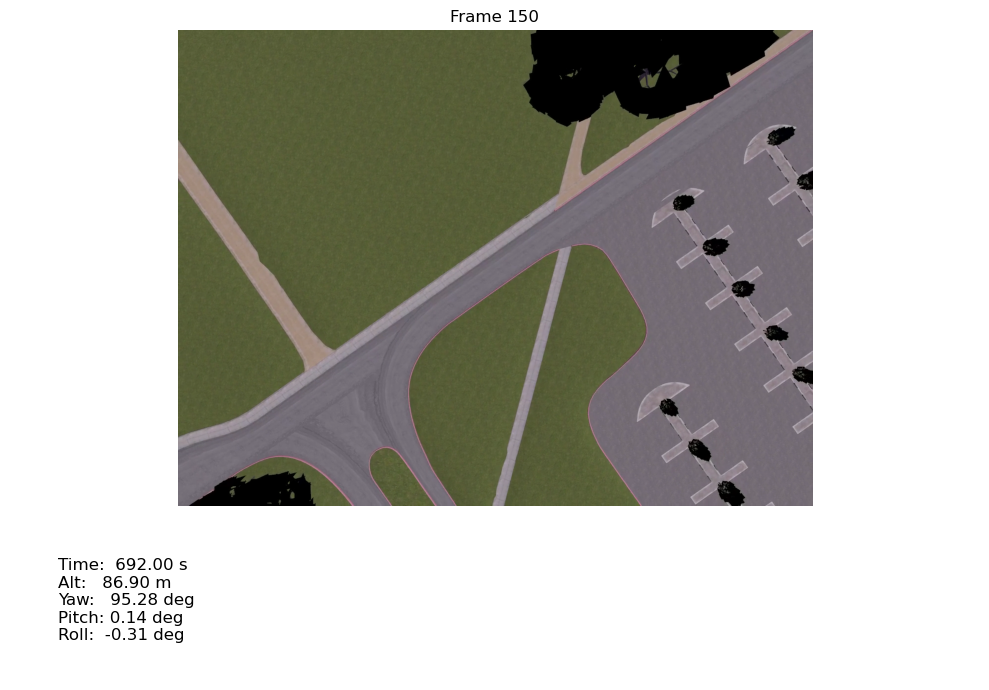

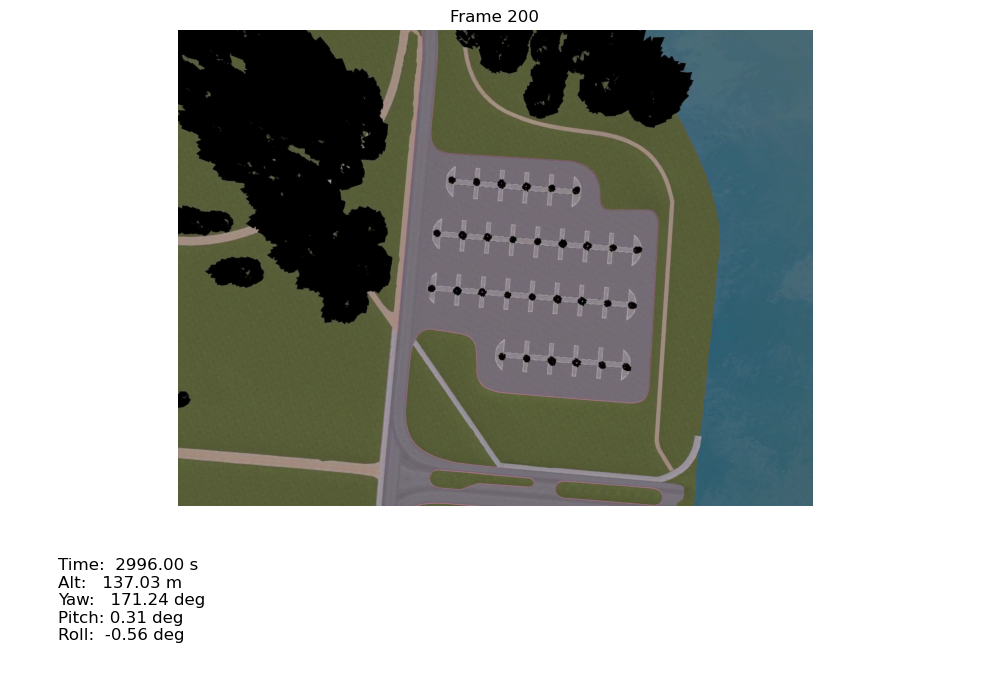

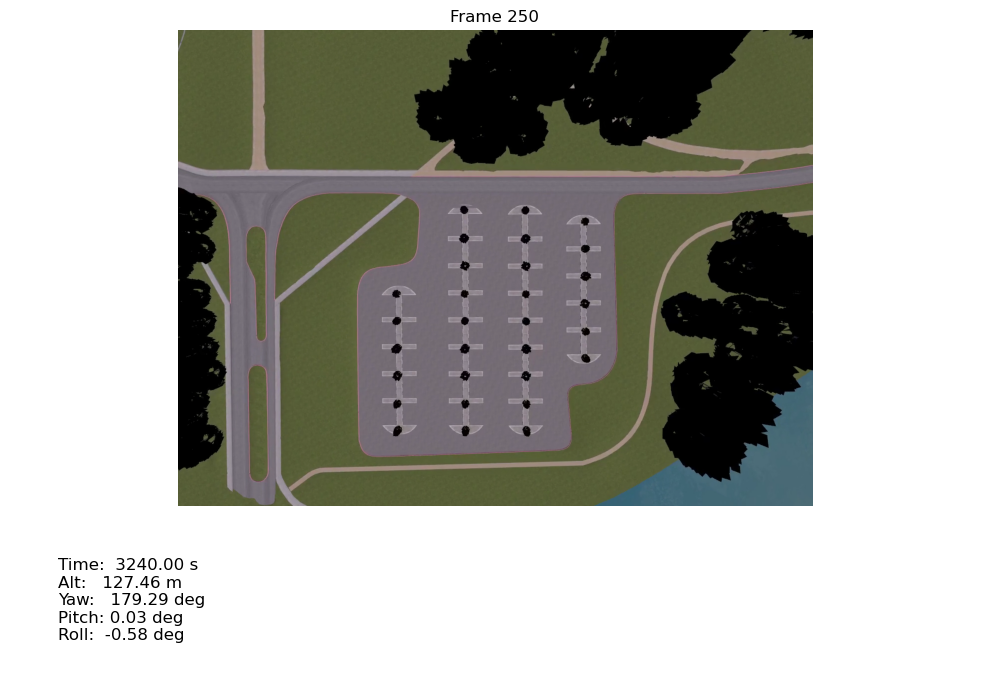

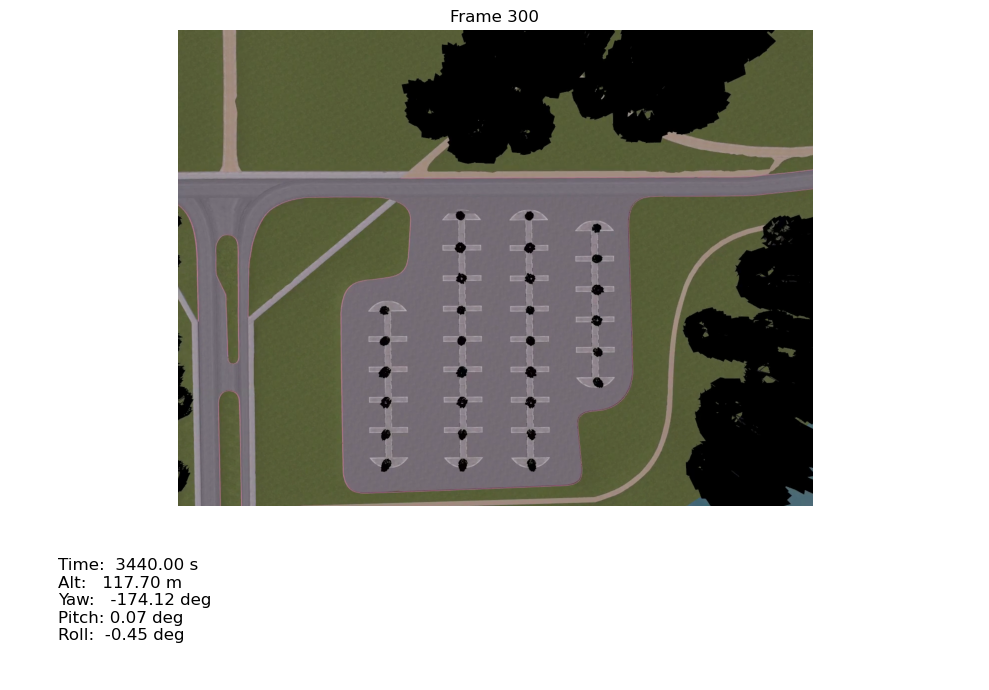

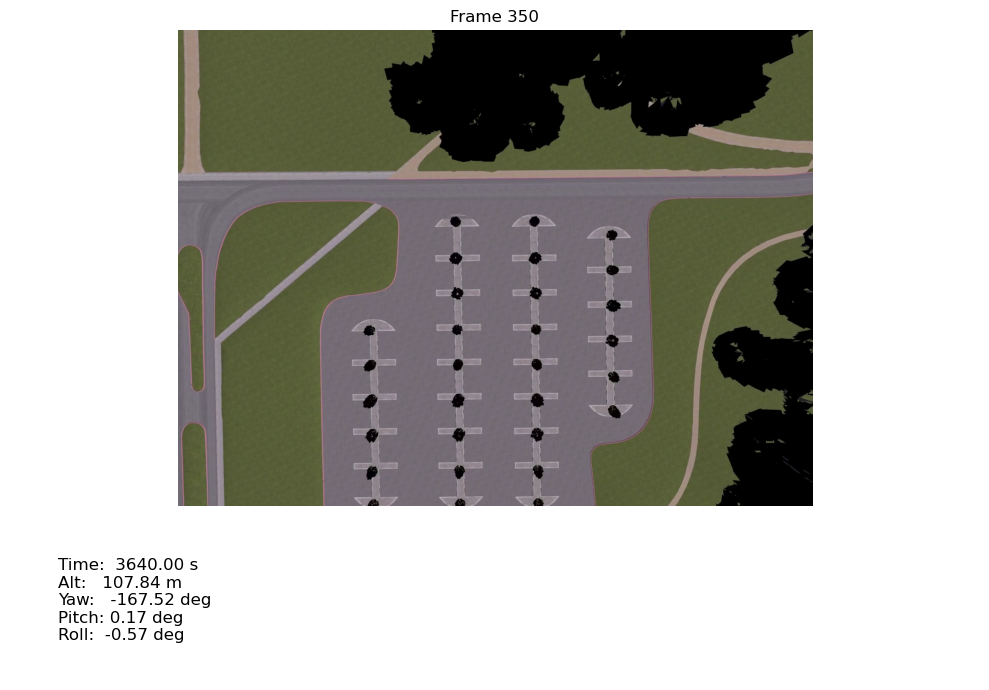

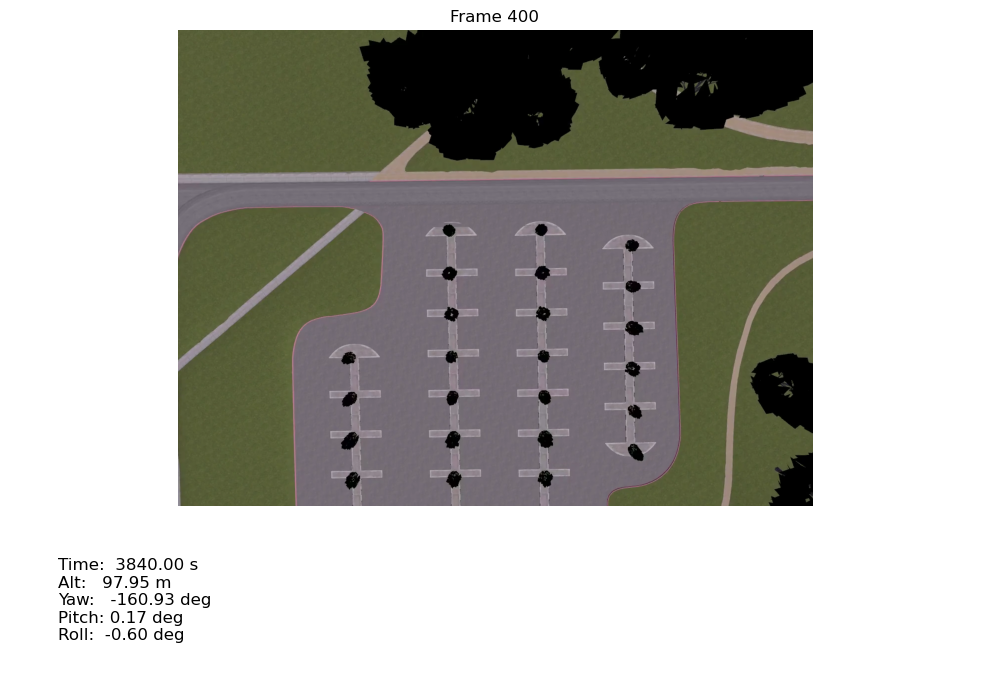

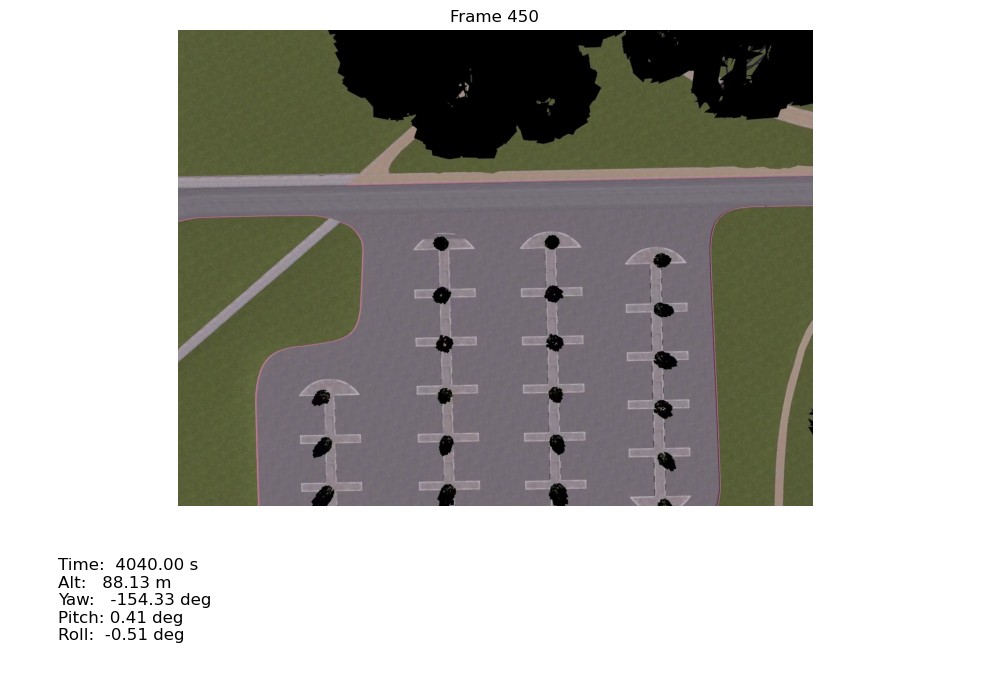

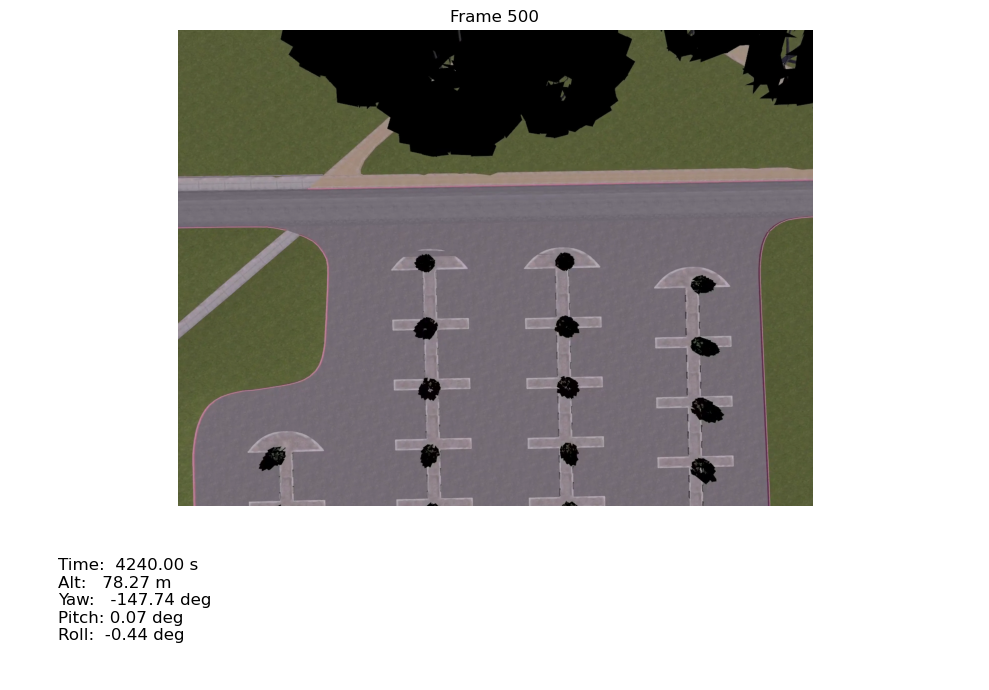

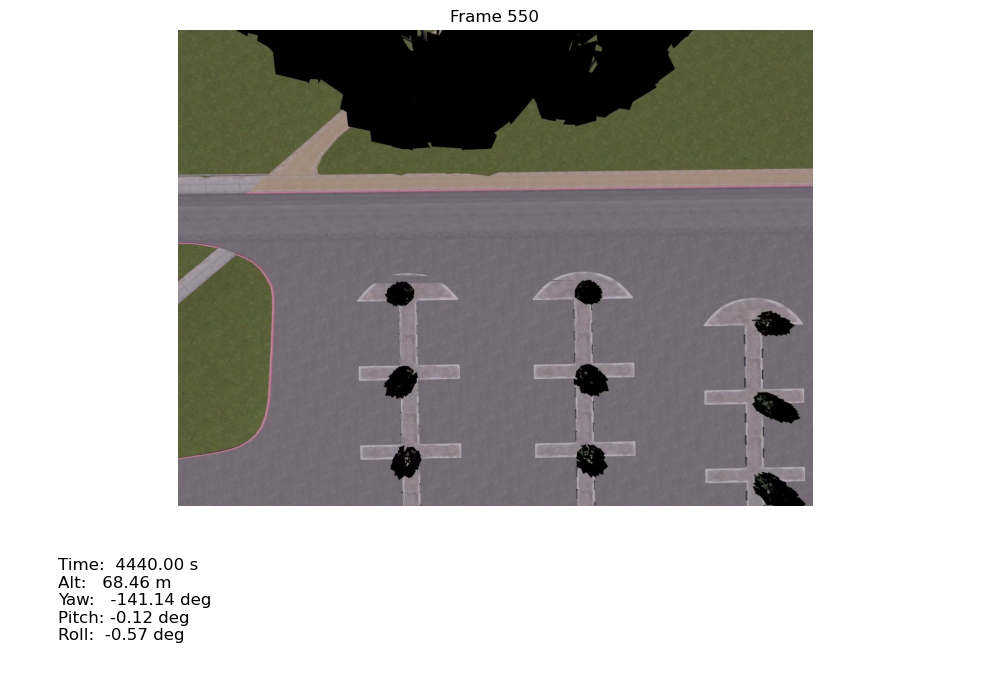

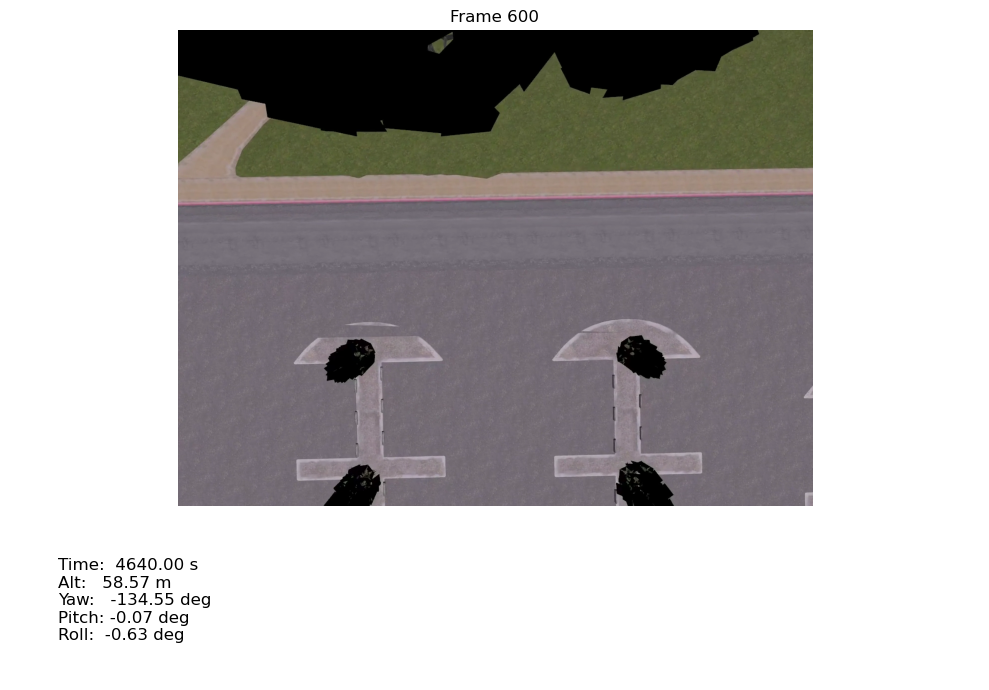

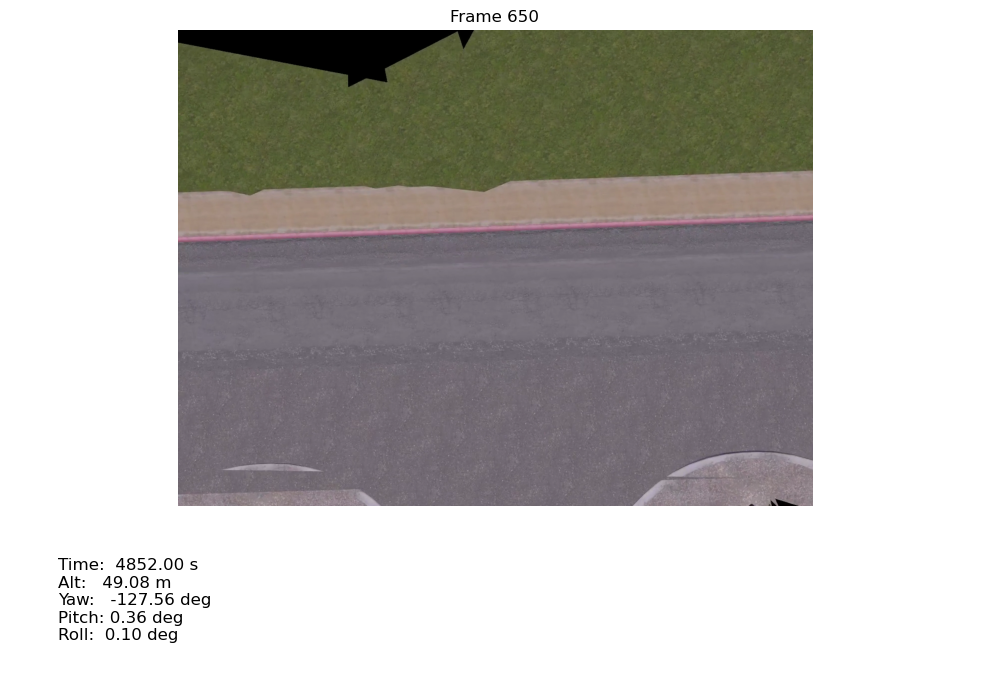

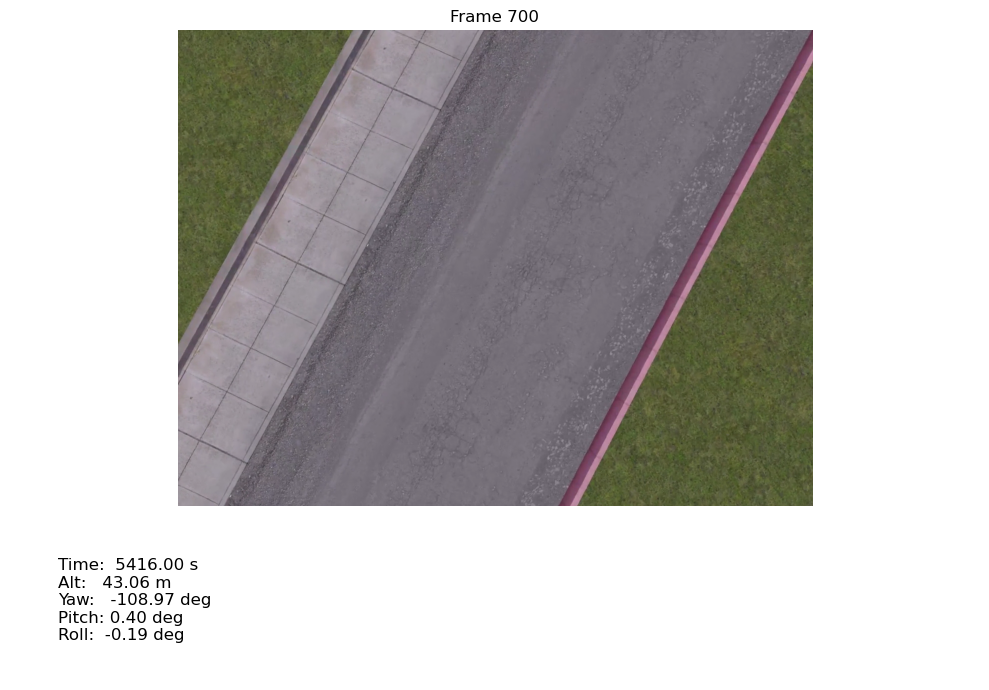

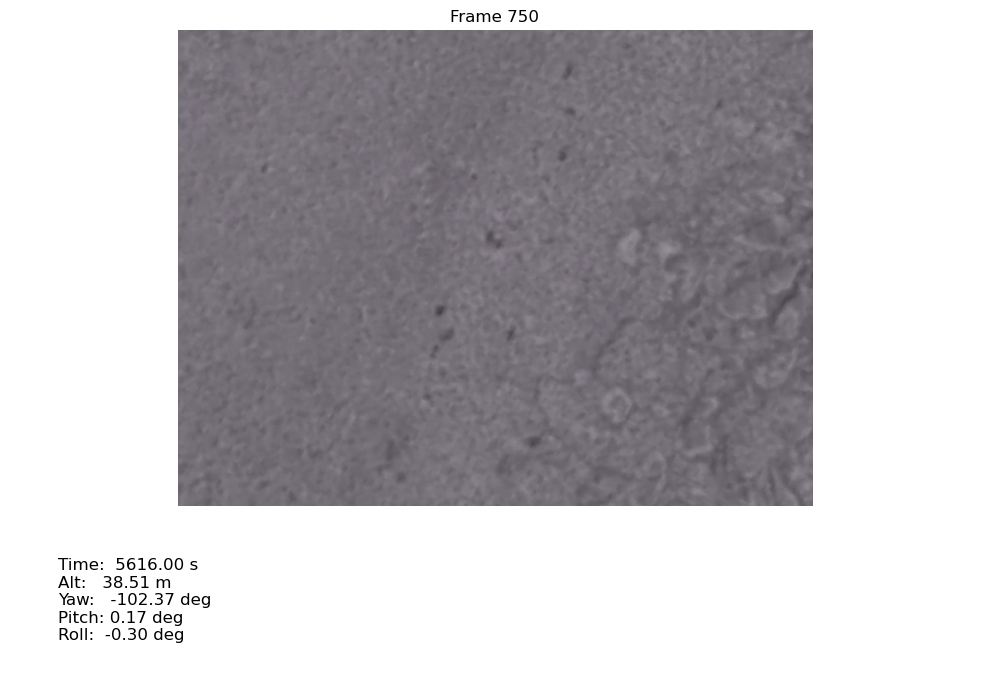

In [7]:
import matplotlib.pyplot as plt

SHOW_EVERY_N = 50

n = min(
    len(data.frames),
    len(data.gps_time),
    len(data.gps_alt),
    len(data.yaw),
    len(data.pitch),
    len(data.roll),
)

for i in range(0, n, SHOW_EVERY_N):
    fig, axes = plt.subplots(
        2, 1,
        figsize=(10, 7),
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # ---------- IMAGE ----------
    axes[0].imshow(data.frames[i])
    axes[0].set_title(f"Frame {i}")
    axes[0].axis("off")

    # ---------- TELEMETRY ----------
    text = (
        f"Time:  {data.gps_time[i]:.2f} s\n"
        f"Alt:   {data.gps_alt[i]:.2f} m\n"
        f"Yaw:   {data.yaw[i]:.2f} deg\n"
        f"Pitch: {data.pitch[i]:.2f} deg\n"
        f"Roll:  {data.roll[i]:.2f} deg"
    )

    axes[1].text(
        0.05, 0.5,
        text,
        fontsize=12,
        va="center",
        ha="left"
    )
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


In [8]:
import numpy as np
import cv2

frames = data.frames

feature_params = dict(
    maxCorners=200,
    qualityLevel=0.3,
    minDistance=7,
    blockSize=7
)

lk_params = dict(
    winSize=(15, 15),
    maxLevel=2,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)

dx_list = []
dy_list = []

old_gray = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

for i in range(1, len(frames)):
    frame_gray = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)

    # If no points to track, re-detect
    if p0 is None or len(p0) == 0:
        p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
        if p0 is None:
            continue

    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # If tracking failed completely, re-detect points and skip
    if p1 is None or st is None:
        old_gray = frame_gray
        p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
        continue

    good_new = p1[st == 1]
    good_old = p0[st == 1]

    if len(good_new) == 0:
        old_gray = frame_gray
        p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
        continue

    flow = good_new - good_old

    dx = np.median(flow[:, 0])
    dy = np.median(flow[:, 1])

    dx_list.append(dx)
    dy_list.append(dy)

    old_gray = frame_gray
    p0 = good_new.reshape(-1, 1, 2)

print("Done!")


Done!


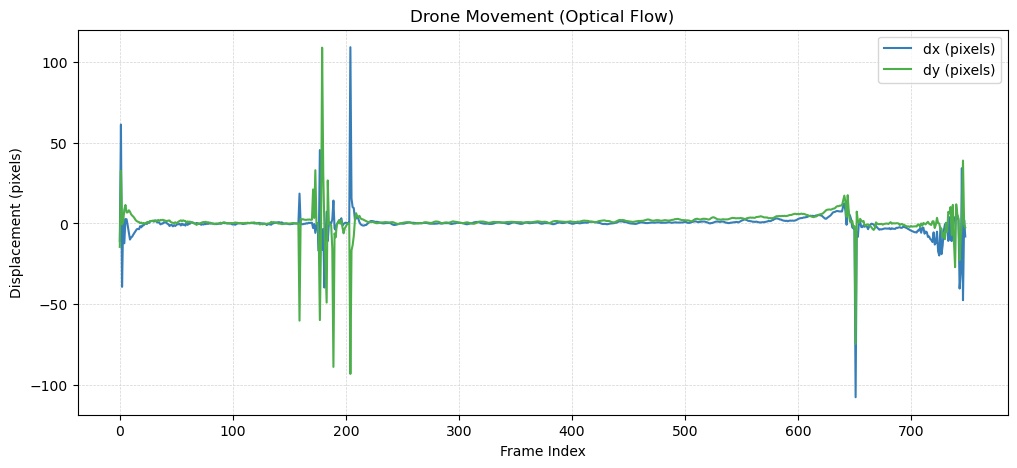

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(dx_list, label="dx (pixels)")
plt.plot(dy_list, label="dy (pixels)")
plt.title("Drone Movement (Optical Flow)")
plt.xlabel("Frame Index")
plt.ylabel("Displacement (pixels)")
plt.legend()
plt.grid(True)
plt.show()


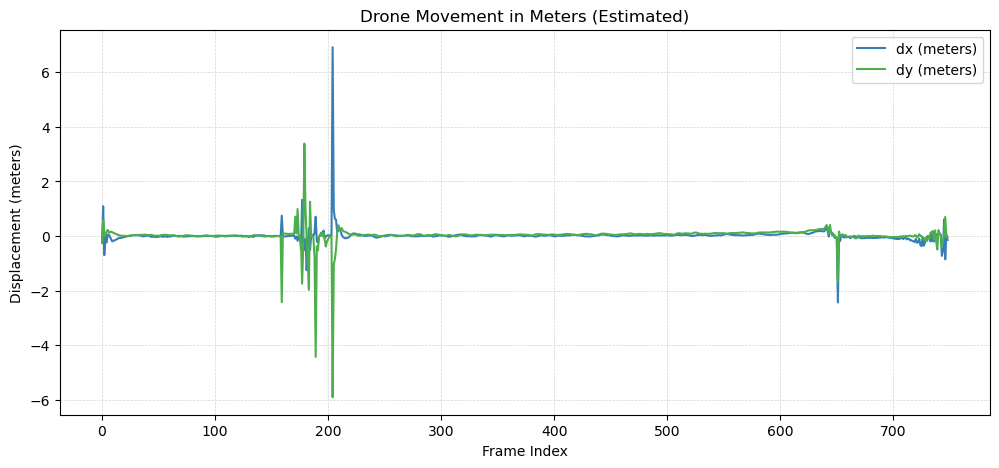

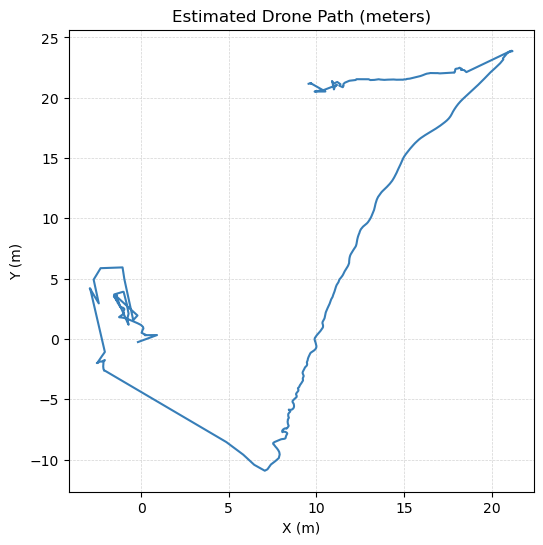

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# ---- camera parameter (change if you know it) ----
FOV_VERTICAL_DEG = 25.0

# ---- compute meters per pixel using altitude for each frame ----
fov_rad = np.deg2rad(FOV_VERTICAL_DEG)

img_h = data.frames[0].shape[0]

# meters per pixel per frame (depends on altitude)
meters_per_pixel = 2 * data.gps_alt[:len(dx_list)] * np.tan(fov_rad / 2) / img_h

dx_m = np.array(dx_list) * meters_per_pixel
dy_m = np.array(dy_list) * meters_per_pixel

# ---- plot in meters ----
plt.figure(figsize=(12, 5))
plt.plot(dx_m, label="dx (meters)")
plt.plot(dy_m, label="dy (meters)")
plt.title("Drone Movement in Meters (Estimated)")
plt.xlabel("Frame Index")
plt.ylabel("Displacement (meters)")
plt.legend()
plt.grid(True)
plt.show()

# ---- plot trajectory ----
x = np.cumsum(dx_m)
y = np.cumsum(dy_m)

plt.figure(figsize=(6, 6))
plt.plot(x, y)
plt.title("Estimated Drone Path (meters)")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.grid(True)
plt.show()


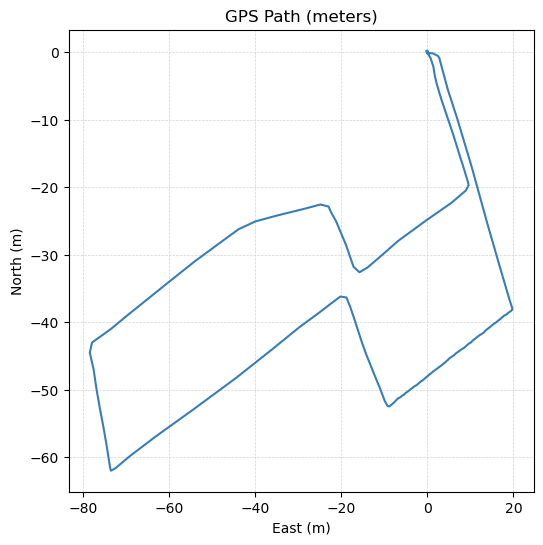

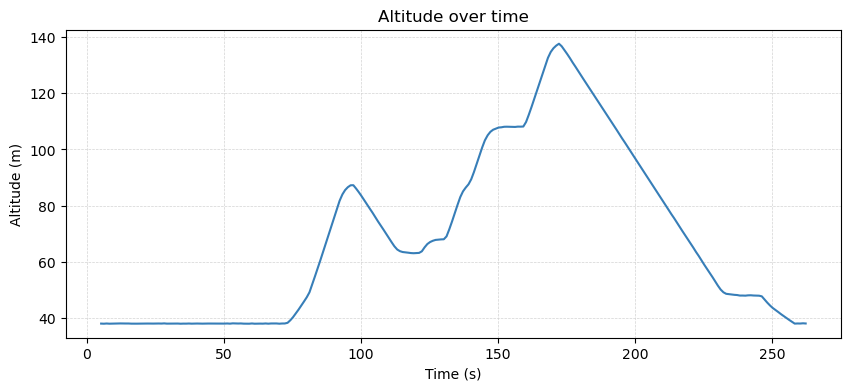

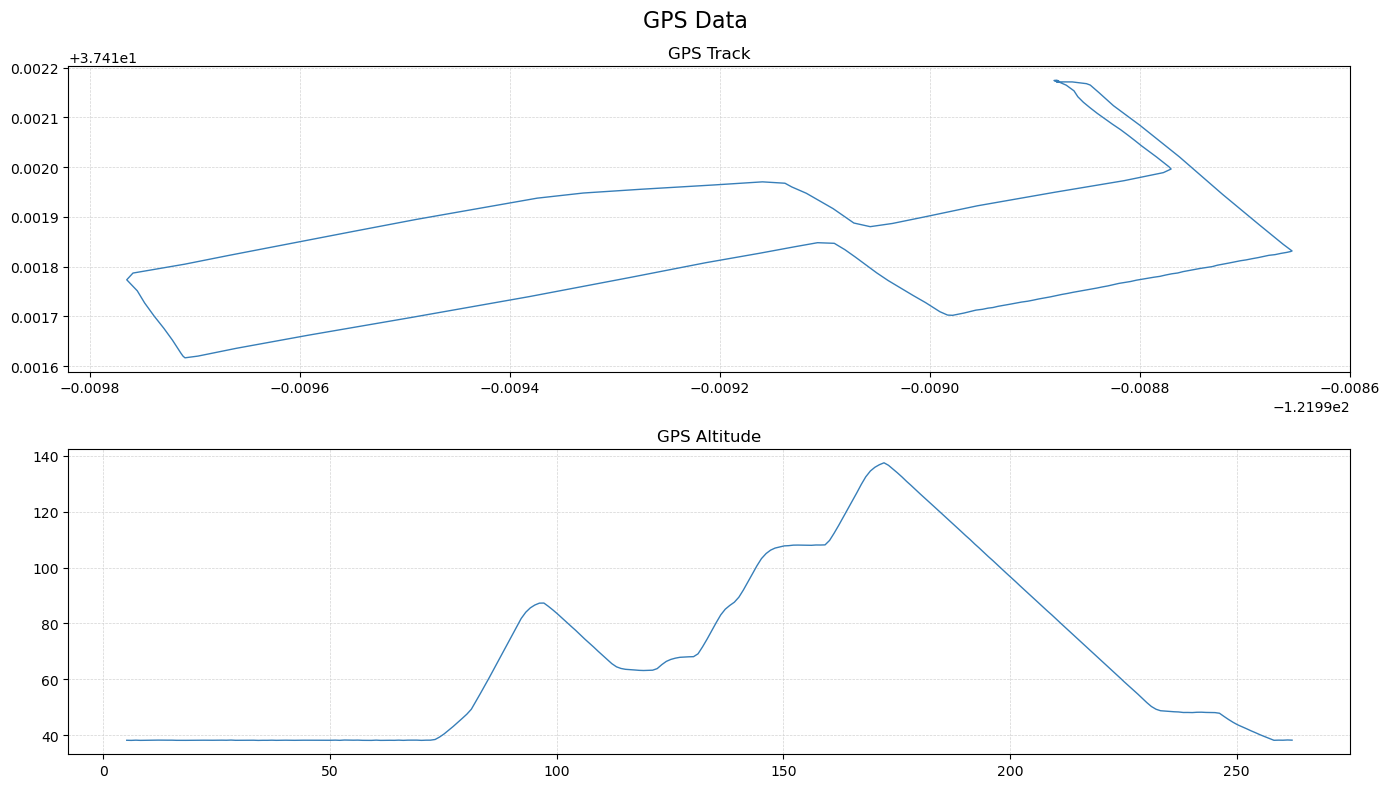

(array([  5.184,   6.172,   7.196,   8.184,   9.176,  10.164,  11.188,
         12.18 ,  13.168,  14.192,  15.18 ,  16.172,  17.196,  18.184,
         19.176,  20.196,  21.188,  22.176,  23.168,  24.192,  25.18 ,
         26.172,  27.192,  28.184,  29.172,  30.196,  31.188,  32.176,
         33.168,  34.188,  35.18 ,  36.168,  37.192,  38.184,  39.172,
         40.196,  41.184,  42.176,  43.164,  44.188,  45.18 ,  46.168,
         47.192,  48.18 ,  49.172,  50.196,  51.184,  52.176,  53.196,
         54.188,  55.176,  56.168,  57.192,  58.18 ,  59.172,  60.192,
         61.184,  62.172,  63.196,  64.188,  65.176,  66.168,  67.188,
         68.18 ,  69.168,  70.192,  71.184,  72.172,  73.196,  74.184,
         75.176,  76.164,  77.188,  78.18 ,  79.168,  80.192,  81.18 ,
         82.172,  83.196,  84.184,  85.176,  86.196,  87.188,  88.176,
         89.168,  90.192,  91.18 ,  92.172,  93.192,  94.184,  95.172,
         96.196,  97.188,  98.176,  99.168, 100.188, 101.18 , 102.168,
      

In [17]:
from utilities.PX4CSVPlotter import PX4CSVPlotter

# Wczytaj i wyświetl wszystkie wykresy
plotter = PX4CSVPlotter(csv_path)
plotter.plot_gps()